In [1]:
print('\033[1m'+'Regression Model using Housing dataset'+'\033[0m')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Regression Model using Housing dataset


Correlation between the features to determine the most significant features: 
From the heat map, we can infer that that there is strong positive correlation between median_income(one of the features) and median_house_value(value to be predicted).


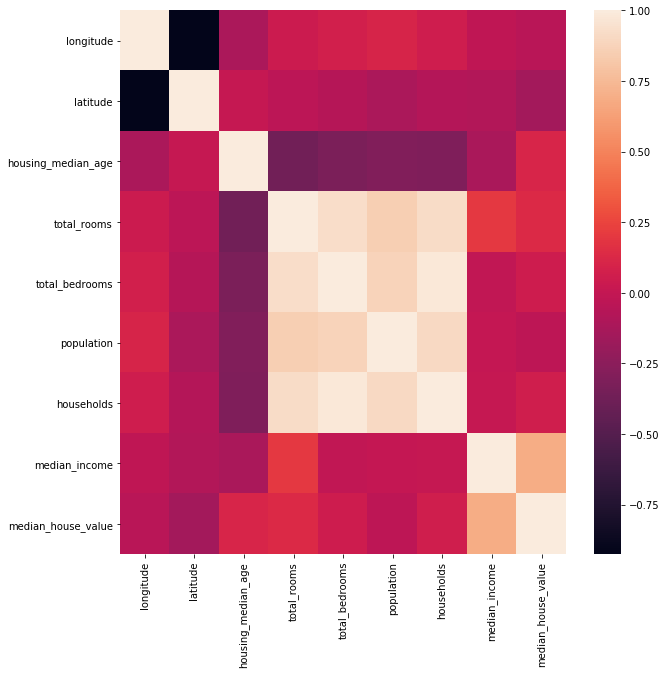

In [2]:
dataset = pd.read_csv('/home/ubuntu/IntroToML/housing.csv')

print('Correlation between the features to determine the most significant features: ')

cor = dataset.corr()

plt.figure(figsize=(10,10))
sns.heatmap(cor)

cor_median_income = np.corrcoef(dataset['median_house_value'],dataset['median_income'])

print('From the heat map, we can infer that that there is strong positive correlation between median_income(one of'+
      ' the features) and median_house_value(value to be predicted).')

The plot between "median_house_value" and "median_income" is fairly linear.


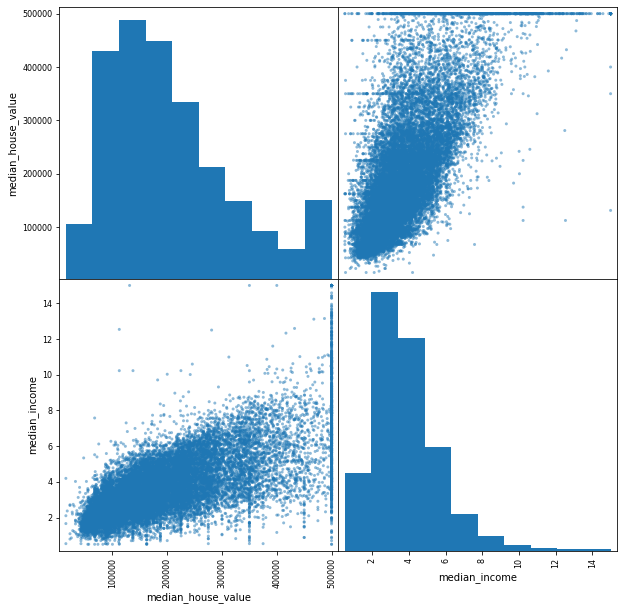

In [3]:
from pandas.plotting import scatter_matrix

attr = ['median_house_value','median_income']
scatter_matrix(dataset[attr],figsize=(10,10))
print('The plot between "median_house_value" and "median_income" is fairly linear.')

In [4]:
print('We will split the dataset into train and test set using the stratified sampling method so that the test'+
      'set is representative of various categories of income in the whole dataset.')

dataset['income_cat'] = np.ceil(dataset['median_income']/1.5)
dataset['income_cat'].where(dataset['income_cat'] < 5,5.0,inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(dataset,dataset['income_cat']):
    train = dataset.loc[train_index]
    test = dataset.loc[test_index]

#dropping income_cat feature
train.drop(['income_cat'],axis=1,inplace=True)
test.drop(['income_cat'],axis=1,inplace=True)

#seperating the feature set and labels in training set
train_labels = train['median_house_value']
train.drop(['median_house_value'],axis=1,inplace=True)

#seperating the feature set and labels in test set
test_labels = test['median_house_value']
test.drop(['median_house_value'],axis=1,inplace=True)

print('\ntrain size: ',train.shape,'\ntrain_labels size: ',train_labels.shape)
print('\ntest size: ',test.shape,'\ntest_labels size: ',test_labels.shape)

We will split the dataset into train and test set using the stratified sampling method so that the testset is representative of various categories of income in the whole dataset.

train size:  (16512, 9) 
train_labels size:  (16512,)

test size:  (4128, 9) 
test_labels size:  (4128,)


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion

In [6]:
rooms,bedrooms,population,household = 3,4,5,6
colnames = []

class DropAttr(BaseEstimator,TransformerMixin):#for feature selection during preprocessing stage
    def __init__(self,attr):
        self.attr = attr
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if set(self.attr).issubset(X.columns):
            x = X.drop(self.attr,axis=1)
        else:
            x = X.copy()
        return x.values

class AddAttr(BaseEstimator,TransformerMixin):#for feature engineering, 3 more features can be added
    def __init__(self,bedrooms_room=True,rooms_household=True,population_household=True):
        self.bedrooms_room = bedrooms_room
        self.rooms_household = rooms_household
        self.population_household = population_household   
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.bedrooms_room:
            X = np.c_[X,X[:,bedrooms]/X[:,rooms]]
            colnames.append('bedrooms_per_room')
        if self.rooms_household:
            X = np.c_[X,X[:,rooms]/X[:,household]]
            colnames.append('rooms_per_household')
        if self.population_household:
            X = np.c_[X,X[:,population]/X[:,household]]
            colnames.append('population_per_household')
        return X

class ColumnLabeler():#to atttach column labels to the  after preprocessing
    def __init__(self,labeldata,data):
        self.labeldata = labeldata
        self.data = data
    def changeLabel(self):
        tmp = pd.DataFrame(self.data,columns=list(self.labeldata[:8])+colnames+['1hour_ocean','inland','near_ocean','near_bay','island'])
        return tmp
#the above function would execute without error if and only if the sample dataset has all the one hot vectors i.e.
#the dataset consists atleast one example of each category of ocean_proximity feature

In [7]:
numpipeline = Pipeline([
    ('drop_feature',DropAttr(train.columns[train.dtypes.values != np.dtype('float64')])),
    ('impute',SimpleImputer(strategy='mean')),
    ('add_attr',AddAttr()),
    ('scaler',StandardScaler())
])

catpipeline = Pipeline([
    ('drop_feature',DropAttr(train.columns[train.dtypes.values != np.dtype('object')])),
    ('one_hot_vectors',OneHotEncoder(sparse=False)),
])

mypipeline = FeatureUnion(transformer_list = [
    ('number_pipeline',numpipeline),
    ('category_pipeline',catpipeline)
])
train1 = train.copy()

temp = mypipeline.fit_transform(train1)
train1 = pd.DataFrame(temp)

temp = ColumnLabeler(train.columns,train1.values)
train_prep = temp.changeLabel()

print('Preview of prepared data:\n')
print(train_prep.head())

Preview of prepared data:

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.156043  0.771950            0.743331    -0.493234       -0.447944   
1  -1.176025  0.659695           -1.165317    -0.908967       -1.039606   
2   1.186849 -1.342183            0.186642    -0.313660       -0.155765   
3  -0.017068  0.313576           -0.290520    -0.362762       -0.399248   
4   0.492474 -0.659299           -0.926736     1.856193        2.410540   

   population  households  median_income  bedrooms_per_room  \
0   -0.636211   -0.420698      -0.614937           0.134997   
1   -0.998331   -1.022227       1.336459          -0.788193   
2   -0.433639   -0.093318      -0.532046           0.383467   
3    0.036041   -0.383436      -1.045566          -0.192503   
4    2.724154    2.570975      -0.441437           0.241700   

   rooms_per_household  population_per_household  1hour_ocean  inland  \
0            -0.312055                 -0.086499          1.0     0.0 

In [8]:
print('Using Linear Model Regressor:\n')
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(train_prep,train_labels)

Using Linear Model Regressor:



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
sample = train.sample(n=10)
sample_prep = mypipeline.transform(sample) 

#if fit_transform() is used instead of transform(), then it would throw an error
#shape of sample_prep returned by fit_transform() and transform() is different, which is root cause of error
#But couldn't figure out why they returned array of different sizes when they both basically invoke same function

prediction = linear_reg.predict(sample_prep)
print('Predicted median_house_value for given data:\n\n ',prediction)

Predicted median_house_value for given data:

  [200495.96248551 289413.52071925 329429.64507176 295980.06122244
 143665.77334475 181900.61825646 253807.53878133 243101.26791824
 269849.34615261 125839.1687069 ]


In [10]:
from sklearn.metrics import mean_squared_error

#estimating training error
train_prediction_lr = linear_reg.predict(train_prep)

test_prep = mypipeline.transform(test)

test_prediction_lr = linear_reg.predict(test_prep)

rmse_train_lr = np.sqrt(mean_squared_error(train_prediction_lr,train_labels))
rmse_test_lr = np.sqrt(mean_squared_error(test_prediction_lr,test_labels))

print('Root mean squared error of training set using Linear Regression: ',rmse_train_lr)
print('Root mean squared error of test set using Linear Regression: ',rmse_test_lr)

print('\nSeems like the Linear Model underfits the data as both train and test rmse are pretty high.')

Root mean squared error of training set using Linear Regression:  68727.6207005888
Root mean squared error of test set using Linear Regression:  66997.77005338887

Seems like the Linear Model underfits the data as both train and test rmse are pretty high.


In [11]:
from sklearn.tree import DecisionTreeRegressor

print('Using Decision Tree Regressor:\n')

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_prep,train_labels)

prediction = tree_reg.predict(sample_prep)
print('Predicted median_house_value for given data:\n\n',prediction)

Using Decision Tree Regressor:

Predicted median_house_value for given data:

 [240900. 236200. 270100. 411200. 275300.  95000. 195500. 173300. 213900.
 184400.]


In [12]:
train_prediction_dt = tree_reg.predict(train_prep)

test_prediction_dt = tree_reg.predict(test_prep)

rmse_train_dt = np.sqrt(mean_squared_error(train_prediction_dt,train_labels))
rmse_test_dt = np.sqrt(mean_squared_error(test_prediction_dt,test_labels))

print('Roots mean squared error of training set using Decision Tree: ',rmse_train_dt)
print('Roots mean squared error of test set using Decision Tree: ',rmse_test_dt)

print('\nSeems like the Decision Tree Regressor excessively overfits the training set and its performance on test set is '+
     'poor than that of Linear Model')

Roots mean squared error of training set using Decision Tree:  0.0
Roots mean squared error of test set using Decision Tree:  69412.98008693632

Seems like the Decision Tree Regressor excessively overfits the training set and its performance on test set is poor than that of Linear Model


In [13]:
from sklearn.ensemble import RandomForestRegressor

print('Using Random Forest Regressor:')

rforest_reg = RandomForestRegressor()
rforest_reg.fit(train_prep,train_labels)

prediction = rforest_reg.predict(sample_prep)
print('Predicted median_house_value for given data:\n\n',prediction)

Using Random Forest Regressor:
Predicted median_house_value for given data:

 [220287. 245457. 280558. 372401. 241438. 115920. 194843. 179150. 225663.
 164348.]


In [14]:
train_prediction_rfr = rforest_reg.predict(train_prep)

test_prediction_rfr = rforest_reg.predict(test_prep)

rmse_train_rfr = np.sqrt(mean_squared_error(train_prediction_rfr,train_labels))
rmse_test_rfr = np.sqrt(mean_squared_error(test_prediction_rfr,test_labels))

print('Roots mean squared error of training set using Random Forest Regressor: ',rmse_train_dt)
print('Roots mean squared error of test set using Random Forest Regressor: ',rmse_test_dt)

print('\nSeems like the Random Forest Regressor excessively overfits the training set and its performance on test set is '+
     'poor than that of Linear Model')

Roots mean squared error of training set using Random Forest Regressor:  0.0
Roots mean squared error of test set using Random Forest Regressor:  69412.98008693632

Seems like the Random Forest Regressor excessively overfits the training set and its performance on test set is poor than that of Linear Model


In [249]:
print('To increase the accuracy we could use regularization and control overfitting of model. In case of linear'+
     'model we may try to find better features to enhance feature engineering.')

To increase the accuracy we could use regularization and control overfitting of model. In case of linearmodel we may try to find better features to enhance feature engineering.
